Attacks

In [2]:
#!pip install opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
import tarfile
import torch
import requests
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torch.utils.data as torch_data
import torchvision.transforms as transforms
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import math
#from google.colab import files

In [ ]:
#### uncomment only if data has not been loaded yet ####


#response = requests.get(f'https://www.comp.nus.edu.sg/~reza/files/dataset_texas.tgz')
#if response.status_code == 200:
#    with open(f'dataset_texas.tgz', 'wb') as file:
#        file.write(response.content)
#    print("Download completed successfully.")
#else:
#    print(f"Failed to download file: {response.status_code}")


### Set up the environment

#### Prepare dataset

In [4]:
with tarfile.open(f'dataset_texas.tgz') as f:
    f.extractall(f'data/')

with open('data/texas/100/feats', 'r') as f:
    features = f.readlines()
with open('data/texas/100/labels', 'r') as f:
    labels = f.readlines()

In [6]:
## build the sampled trainig and test datasets
features_list = [list(map(int, ''.join(feature.split()).split(','))) for feature in features]
labels_list = [int(label.strip()) for label in labels]
size = int(0.8 * len(features))


## base sample size for the inference attack
sample_size = 50

## sample dataset for inference attack
## the choice in this case is deterministic to simplify the fact that we need to keep the same proportions
## of training and test data points
feat_tens = torch.tensor(features_list[size-8*sample_size:size+2*sample_size], dtype=torch.float, requires_grad = True)
l_tens = torch.tensor(labels_list[size-8*sample_size:size+2*sample_size], dtype=torch.long)
dataset = TensorDataset(feat_tens, l_tens)


## true train and test datasets
feat_tens_train = torch.tensor(features_list[size-8*sample_size:size], dtype=torch.float)
l_tens_train = torch.tensor(labels_list[size-8*sample_size:size], dtype=torch.long)
dataset_train = TensorDataset(feat_tens_train, l_tens_train)

#### Prepare model

In [171]:
current_dir = os.getcwd()
model_path_S = os.path.join(current_dir,'..','Models','model_S.pth')
model_path_Y = os.path.join(current_dir,'..','Models','model_Y_saved_properly.pth')
model_path_X = os.path.join(current_dir,'..','Models','model_X_saved_properly.pth')
model_path_E = os.path.join(current_dir,'..','Models','model_E_saved_properly.pth')

In [173]:
## models class
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()
        self.fc1 = nn.Linear(6169, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 101)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [175]:
## load the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_state_dict_S = torch.load(model_path_S)
model_state_dict_X = torch.load(model_path_Y)
model_state_dict_Y = torch.load(model_path_X)
model_state_dict_E = torch.load(model_path_E)
model_S = NetSeq()
model_X = NetSeq()
model_Y = NetSeq()
model_E = NetSeq()
model_S.load_state_dict(model_state_dict_S)
model_S.eval()
model_Y.load_state_dict(model_state_dict_Y)
model_Y.eval()
model_X.load_state_dict(model_state_dict_X)
model_X.eval()
model_E.load_state_dict(model_state_dict_E)
model_E.eval()


models = {'model_S': model_S, 'model_X': model_X, 'model_Y': model_Y, 'model_E': model_E}

## Black box attack: measure accuracy

For this first attack the setup is black box, which means that we can evaluate the model but we do not know the parameters of the model and its hidden layers.
On top of that we may also assume that we know which is the loss function used to train the model.

The attack is very simple: we evaluate the model on every point of our sample dataset and measure the accuracy of the prediction and sort them increasingly.
For this first attempt we assume to know the proportion of training points in the sample dataset (in this case $80\%$), so our predited members will be
the first $80\%$ of sorted data points.

The argument behind this kind of attack is that the model is more likely to be more accurate on data that it has already seen.

We're going to try this for each of the loaded models, where model S is the one with no privacy.

In [116]:
criterion = nn.CrossEntropyLoss()
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
trainloader = DataLoader(dataset_train, batch_size=1, shuffle=False)
train_features_set = {tuple(features.numpy().flatten()) for features, _ in trainloader}
sample_size = 50

# Dictionaries to store results for each model
all_results = {}
all_sorted_results = {}
all_predicted_members = {}
max_losses = {}
int_max_losses = {}
count_accuracy = {}

for model_name, model in models.items():
    results = []
    with torch.no_grad():
        for feat, lab in data_loader:
            # Forward pass
            outputs = model(feat)    
            # Compute loss
            loss = criterion(outputs, lab) 
            # Store the feature values and loss
            results.append((feat.numpy(), lab.numpy(), loss.item()))

    # Sort results by loss in increasing order
    sorted_results = sorted(results, key=lambda x: x[2])
    #sample_size = len(sorted_results) // 8  # Adjust sample_size as needed
    predicted_members = sorted_results[:8*sample_size]

    # Store results for this model
    all_results[model_name] = results
    all_sorted_results[model_name] = sorted_results
    all_predicted_members[model_name] = predicted_members

    # Max loss as an upper bound for threshold in a ROC curve
    max_loss = sorted_results[-1][2]
    max_loss2 = predicted_members[-1][2]
    int_max_loss = math.ceil(max_loss)

    max_losses[model_name] = max_loss
    int_max_losses[model_name] = int_max_loss
    
    count_actual_members = sum(1 for feats, lab, loss in predicted_members if tuple(feats.flatten()) in train_features_set)
    accuracy = count_actual_members/(8*sample_size)
    count_accuracy[model_name] = {
        'members_predicted_correctly': count_actual_members,
        'accuracy': accuracy
    }
     
for model_name in models.keys():
    print(f"Model: {model_name}")
    #print(f"Total sorted results: {len(all_sorted_results[model_name])}")
    print(f"Number of predicted members: {len(all_predicted_members[model_name])}")
    #print(f"Max loss: {max_losses[model_name]['max_loss']}")
    #print(f"Max loss (predicted members): {max_losses[model_name]['max_loss2']}")
    print(f"Members predicted correcty: {count_accuracy[model_name]['members_predicted_correctly']}")
    print(f"Accuracy: {count_accuracy[model_name]['accuracy']}")
    print("-" * 40)

Model: model_S
Number of predicted members: 400
Members predicted correcty: 326
Accuracy: 0.815
----------------------------------------
Model: model_X
Number of predicted members: 400
Members predicted correcty: 314
Accuracy: 0.785
----------------------------------------
Model: model_Y
Number of predicted members: 400
Members predicted correcty: 317
Accuracy: 0.7925
----------------------------------------
Model: model_E
Number of predicted members: 400
Members predicted correcty: 313
Accuracy: 0.7825
----------------------------------------


If we drop the assumption of knowing the proportion of training data in the sample dataset, we need to set a threshold value for the losses
as a decision boundary for the membership inference.

By changing this value linearly up to the maximum loss value we can study the accuracy of the method using a ROC curve.

Model: model_S
Model: model_X
Model: model_Y
Model: model_E


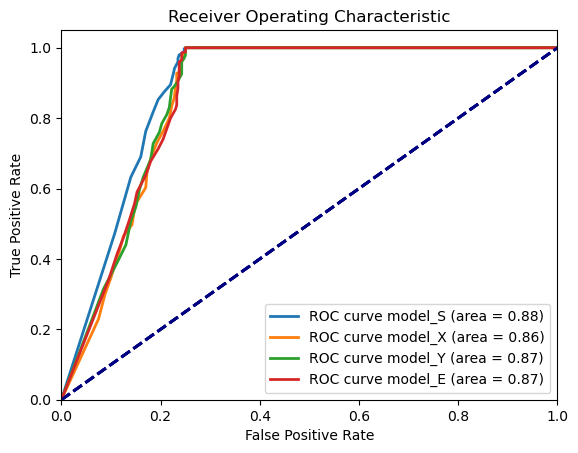

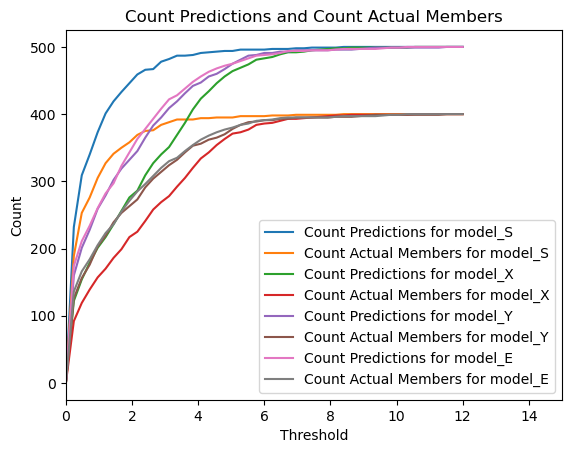

In [181]:
roc_data = {}
max_int_max_loss = max(iml for iml in int_max_losses.values())
# number of segments for the loss intervall
m = 50

for model_name in models.keys():
    sorted_results = all_sorted_results[model_name]
    int_max_loss = int_max_losses[model_name]
    #sample_size = len(sorted_results) // 8  # Adjust sample_size as needed
    
    TP_count = []
    FP_count = []
    TN_count = []
    FN_count = []
    thresholds = []
    count_predictions = []
    count_act_mems = []
    #print(f"Model: {model_name}")
    for i in range(m + 1):
        thresh = i / m * max_int_max_loss
        thresholds.append(thresh)
        #print(thresh)
        prediction = [item for item in sorted_results if item[2] < thresh]
        count_prediction = len(prediction)
        count_act_mem = sum(1 for feats, lab, loss in prediction if tuple(feats.flatten()) in train_features_set)
        #print(count_prediction, count_act_mem)
        TP_count.append(count_act_mem)
        FP_count.append(count_prediction - count_act_mem)
        TN_count.append(8 * sample_size - count_prediction + count_act_mem)
        FN_count.append(8 * sample_size - count_act_mem)
        count_predictions.append(count_prediction)
        count_act_mems.append(count_act_mem)
        
    TPR = [TP / (TP + FN) for TP, FN in zip(TP_count, FN_count)]  # True Positive Rate
    FPR = [FP / (FP + TN) for FP, TN in zip(FP_count, TN_count)]  # False Positive Rate

    TPR.append(1)
    FPR.append(1)

    roc_auc = np.trapz(TPR, FPR)
    
    roc_data[model_name] = {
        'TPR': TPR,
        'FPR': FPR,
        'roc_auc': roc_auc,
        'thresholds': thresholds,
        'count_predictions': count_predictions,
        'count_act_mems': count_act_mems
    }
    #print("-" * 40)
# Plot ROC curves
plt.figure()
for model_name in models.keys():

    plt.plot(roc_data[model_name]['FPR'], roc_data[model_name]['TPR'], lw=2, 
             label=f'ROC curve {model_name} (area = %0.2f)' % roc_data[model_name]['roc_auc'])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plt.show()
    
plt.figure()
for model_name in models.keys():
    plt.plot(roc_data[model_name]['thresholds'], roc_data[model_name]['count_predictions'], label=f'Count Predictions for {model_name}')
    plt.plot(roc_data[model_name]['thresholds'], roc_data[model_name]['count_act_mems'], label=f'Count Actual Members for {model_name}')
    plt.xlim([0.0, 15])
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title(f'Count Predictions and Count Actual Members')
    plt.legend(loc="upper right")
plt.legend(loc="lower right")
plt.show()

## White box attack: measure gradient norm

This attack is instead a white box, which means that we can evaluate the model and we can access the parameters of the model and its hidden layers.
We use this to compute the gradient of the model with respect to its features (which measures how much the input should move to fid the model's parameters). The idea is that a datapoint used for training should already fit the training parameters well enough, as a representative of its class, thus we expect a member to have small gradient.

Similarly as before, we begin by assuming that we know the proportion of training points in the sample dataset, and then again we change the decision threshold and analyze the result using ROC curve and confronting the accuracy of the prediction.

In [185]:
def compute_gradient_norm_wrt_input(model, feature, label, criterion):

    feature, label = feature, label
    model = model.to('cpu')
    output = model(feature)
    loss = criterion(output, label)
    feature.retain_grad()
    model.train()
    loss.backward()
    
    grads = feature.grad
    grad_norm = torch.sqrt(torch.sum(grads ** 2)).item()
    
    return grad_norm

In [187]:
train_features_set = {tuple(features.numpy().flatten()) for features, _ in trainloader}

# Dictionaries to store results for each model
all_results_gn = {}
all_sorted_results_gn = {}
all_predicted_members_gn = {}
max_gradnorm = {}
int_max_gradnorm = {}
count_accuracy_gn = {}

for model_name, model in models.items():
    results_gn = []
    
    for feat, lab in data_loader:
        grad_norm = compute_gradient_norm_wrt_input(model, feat, lab, criterion)
        results_gn.append((feat.detach().numpy(), lab.numpy(), grad_norm))

    # Sort results by loss in increasing order
    sorted_results = sorted(results_gn, key=lambda x: x[2])
    #sample_size = len(sorted_results) // 8  # Adjust sample_size as needed
    predicted_members = sorted_results[:8*sample_size]

    # Store results for this model
    all_results_gn[model_name] = results_gn
    all_sorted_results_gn[model_name] = sorted_results
    all_predicted_members_gn[model_name] = predicted_members

    # Max loss as an upper bound for threshold in a ROC curve
    max_loss = sorted_results[-1][2]
    max_loss2 = predicted_members[-1][2]
    int_max_loss = math.ceil(max_loss)

    max_gradnorm[model_name] = max_loss
    int_max_gradnorm[model_name] = int_max_loss
    
    count_actual_members = sum(1 for feats, lab, loss in predicted_members if tuple(feats.flatten()) in train_features_set)
    accuracy = count_actual_members/(8*sample_size)
    count_accuracy_gn[model_name] = {
        'members_predicted_correctly': count_actual_members,
        'accuracy': accuracy
    }
     
for model_name in models.keys():
    print(f"Model: {model_name}")
    #print(f"Total sorted results: {len(all_sorted_results[model_name])}")
    print(f"Number of predicted members: {len(all_predicted_members_gn[model_name])}")
    #print(f"Max loss: {max_losses[model_name]['max_loss']}")
    #print(f"Max loss (predicted members): {max_losses[model_name]['max_loss2']}")
    print(f"Members predicted correcty: {count_accuracy_gn[model_name]['members_predicted_correctly']}")
    print(f"Accuracy: {count_accuracy_gn[model_name]['accuracy']}")
    print("-" * 40)

Model: model_S
Number of predicted members: 400
Members predicted correcty: 322
Accuracy: 0.805
----------------------------------------
Model: model_X
Number of predicted members: 400
Members predicted correcty: 317
Accuracy: 0.7925
----------------------------------------
Model: model_Y
Number of predicted members: 400
Members predicted correcty: 317
Accuracy: 0.7925
----------------------------------------
Model: model_E
Number of predicted members: 400
Members predicted correcty: 316
Accuracy: 0.79
----------------------------------------


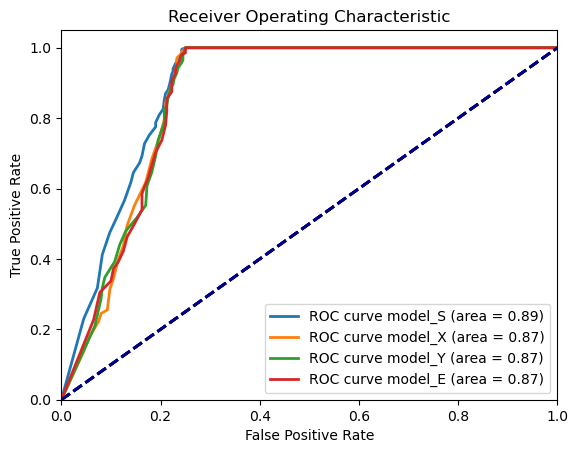

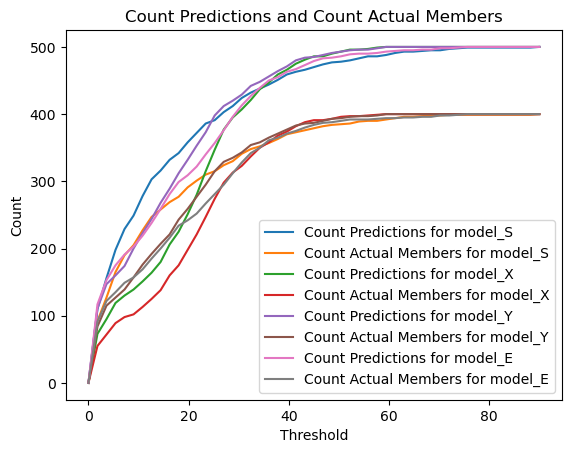

In [191]:
roc_data_gn = {}
max_int_max_gradnorm = max(iml for iml in int_max_gradnorm.values())


for model_name in models.keys():
    sorted_results = all_sorted_results_gn[model_name]
    #int_max_loss = int_max_gradnorm[model_name]
    #sample_size = len(sorted_results) // 8  # Adjust sample_size as needed
    
    TP_count = []
    FP_count = []
    TN_count = []
    FN_count = []
    thresholds = []
    count_predictions = []
    count_act_mems = []
    #print(f"Model: {model_name}")
    for i in range(m + 1):
        thresh = i / m * max_int_max_gradnorm
        thresholds.append(thresh)
        #print(thresh)
        prediction = [item for item in sorted_results if item[2] < thresh]
        count_prediction = len(prediction)
        count_act_mem = sum(1 for feats, lab, loss in prediction if tuple(feats.flatten()) in train_features_set)
        #print(count_prediction, count_act_mem)
        TP_count.append(count_act_mem)
        FP_count.append(count_prediction - count_act_mem)
        TN_count.append(8 * sample_size - count_prediction + count_act_mem)
        FN_count.append(8 * sample_size - count_act_mem)
        count_predictions.append(count_prediction)
        count_act_mems.append(count_act_mem)
        
    TPR = [TP / (TP + FN) for TP, FN in zip(TP_count, FN_count)]  # True Positive Rate
    FPR = [FP / (FP + TN) for FP, TN in zip(FP_count, TN_count)]  # False Positive Rate

    TPR.append(1)
    FPR.append(1)

    roc_auc = np.trapz(TPR, FPR)
    
    roc_data_gn[model_name] = {
        'TPR': TPR,
        'FPR': FPR,
        'roc_auc': roc_auc,
        'thresholds': thresholds,
        'count_predictions': count_predictions,
        'count_act_mems': count_act_mems
    }
    #print("-" * 40)
# Plot ROC curves
plt.figure()
for model_name in models.keys():

    plt.plot(roc_data_gn[model_name]['FPR'], roc_data_gn[model_name]['TPR'], lw=2, 
             label=f'ROC curve {model_name} (area = %0.2f)' % roc_data_gn[model_name]['roc_auc'])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plt.show()
    
plt.figure()
for model_name in models.keys():
    plt.plot(roc_data_gn[model_name]['thresholds'], roc_data_gn[model_name]['count_predictions'], label=f'Count Predictions for {model_name}')
    plt.plot(roc_data_gn[model_name]['thresholds'], roc_data_gn[model_name]['count_act_mems'], label=f'Count Actual Members for {model_name}')
    #plt.xlim([0.0, 15])
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title(f'Count Predictions and Count Actual Members')
    plt.legend(loc="upper right")
plt.legend(loc="lower right")
plt.show()